In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')
import matplotlib.pyplot as plt

old_stdout = sys.stdout

In [2]:
from src.game import Game
from src.player_track import PlayerTracking
from src.vbs import print_log, BeamSearchHelper, get_beam_search_helper

In [3]:
# dataset
meta_tr_pos_set = np.load('data/meta_tr_pos_set_conn.npy', allow_pickle=True)
meta_te_pos_set = np.load('data/meta_te_pos_set_conn.npy', allow_pickle=True)

In [4]:
def train_and_test(pos_set, sigma_n2, p, beta, beam_size=1, verbose=False):
    x_olds, x_curs, x_news = pos_set[:-2], pos_set[1:-1], pos_set[2:]
    folder_name = f'./ckpt/div_beam/validation/ckpt_vbs_p{p}_beta{beta}_sigma{sigma_n2}_b{beam_size}/'
#     if verbose:
#         os.mkdir(folder_name)
#         sys.stdout = open(folder_name + '/out.txt', 'a')
    prior_logodds = np.log(p/(1-p))
    bsh = get_beam_search_helper(folder_name + '/helper.pkl', 
                                 save_folder=folder_name, 
                                 beam_size=beam_size, 
                                 diffusion=beta, 
                                 jump_bias=prior_logodds,
                                 permanent_store_every_tasks=40,
                                 verbose=verbose)

    logp_preds, logp_preds_1st = [], []
    for task_id, (x_old, x_cur, x_new) in enumerate(zip(x_olds, x_curs, x_news)):
        if (task_id+1) % 2000 == 0:
            print('='*75)
            print_log(f"Start task {task_id}.")

        if task_id <= bsh.task_id:
            print_log(f"Task {task_id} is already trained. Skip training.")
            continue

        hypotheses = bsh.get_new_hypotheses_args(x_old, x_cur, x_new)

        param_set, elbos, test_y_preds = [], [], []
        num_hypotheses = len(hypotheses)
        for hypothesis in hypotheses:
            (model_name,
            s_t,
            diffusion,
            [mu, Lambda],
            x_old, 
            x_cur, 
            x_new) = hypothesis

            # initialization
            track_model = PlayerTracking(sigma_n2=sigma_n2, mu=mu, Lambda=Lambda)

            # broaden if required
            if s_t == 1:
                track_model.broaden_temper(diffusion) # beta = diffusion

            # compute predictive probability
            log_marginal_likelihood = track_model.log_marginal_likelihood(x_old, x_cur)
            elbos.append(log_marginal_likelihood)

            # absorb new evidence
            track_model.update(x_old, x_cur, compute_cov=True)

            # save weights
            param = track_model.get_params()
            param_set.append(param)

            test_y_preds.append(track_model.log_marginal_likelihood(x_cur, x_new))

        bsh.absorb_new_evidence_and_prune_beams(elbos, param_set)

        test_y_pred = bsh.weighted_test_probability(test_y_preds)
        logp_preds.append(test_y_pred)
        # most likely probability
        test_y_pred_1st = test_y_preds[bsh._indices[0]]
        logp_preds_1st.append(test_y_pred_1st)

    return logp_preds, logp_preds_1st, bsh

In [5]:
# select one dataset
pos = meta_te_pos_set[8]

x = pos[:,0]
y = pos[:,1]
t = np.arange(len(x))

# initialize plot
fig = plt.Figure(figsize=(7, 5))
ax = fig.subplots(1,1)

# read in the court png file
court = plt.imread("court.png")

# Plot the movemnts as scatter plot

skip_num = 2 # plot once every `skip_num`
ax.scatter(x[::skip_num], y[::skip_num], s=10, zorder=1, alpha=0.5, label='Player Trajectory')

ax.set_xlim(0,100)

(0.0, 100.0)

In [6]:
def vbs_run(beam_size, beta, color_name, marker='o', alpha=0.6, markersize=30):
    # look at the changepoints
    beam_size = beam_size
    sigma_n2 = 0.1
    p = 0.503
    beta = beta
    verbose = False

    pos = meta_te_pos_set[8]

    meta_logp_preds, meta_logp_preds_1st = [], []
    logp_preds, logp_preds_1st, bsh = train_and_test(pos, sigma_n2=sigma_n2, p=p, beta=beta, beam_size=beam_size, verbose=verbose)
    meta_logp_preds.append(np.mean(logp_preds))
    meta_logp_preds_1st.append(np.mean(logp_preds_1st))
    print('Finished. Average log predictive probability and the one of the most probable component:', np.mean(meta_logp_preds), np.mean(meta_logp_preds_1st))

    s_t = bsh.latest_task_res[0]['decisions']
    s_t = np.array(list(s_t))
    cp_indices = np.where(s_t == '1')[0]
    cp_indices += 1

    # Plot changepoints
    x_cp = x[cp_indices]
    y_cp = y[cp_indices]
    ax.scatter(x_cp, y_cp, c=color_name, marker=marker, s=markersize, zorder=1, alpha=alpha, label=f'Detected Changepoints ($\\beta={beta}$)')

In [7]:
vbs_run(beam_size=1, beta=0.8, color_name='C9', marker='p', alpha=0.3, markersize=100)
vbs_run(beam_size=1, beta=0.6, color_name='C4', marker='o', alpha=0.5, markersize=100)
vbs_run(beam_size=1, beta=0.3, color_name='C1', marker='*', alpha=1.0, markersize=200)

Finished. Average log predictive probability and the one of the most probable component: 0.23878806047846873 0.23878806047846873
Finished. Average log predictive probability and the one of the most probable component: 0.15029840771000663 0.15029840771000663
Finished. Average log predictive probability and the one of the most probable component: 0.0499110543299222 0.0499110543299222


In [8]:
ax.imshow(court, zorder=0, extent=[0,100,50,0])
ax.legend(fontsize=12, loc='upper left')

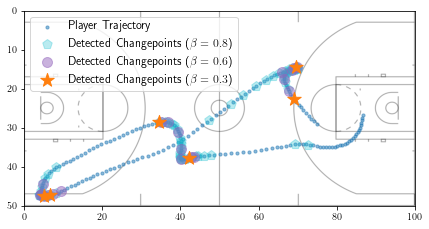

In [9]:
fig

In [11]:
# fig.savefig('./ablation.png', bbox_inches='tight')